In [67]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: white;
}
</style>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

ncolors = 1024
color_array1 = plt.get_cmap('RdBu')(range(ncolors))
color_array2 = plt.get_cmap('PuOr')(range(ncolors))
color_array3 = plt.get_cmap('PRGn')(range(ncolors))
color_array4 = plt.get_cmap('bwr')(range(ncolors))
color_array5 = plt.get_cmap('Reds_r')(range(ncolors))

# change alpha values
color_array1[:,-1] = abs(np.linspace(-.95, .95, ncolors))
color_array2[:,-1] = abs(np.linspace(-1.0, 1.0, ncolors))
color_array3[:,-1] = abs(np.linspace(-1.0, 1.0, ncolors))
color_array4[:,-1] = abs(np.linspace(-1.0, 1.0, ncolors))
color_array5[:,-1] = abs(np.linspace(0.2, 1.0, ncolors))

# create a colormap object
map_object1 = mcolors.LinearSegmentedColormap.from_list(name = 'RdBuT', colors = color_array1)
map_object2 = mcolors.LinearSegmentedColormap.from_list(name = 'PuOrT', colors = color_array2)
map_object3 = mcolors.LinearSegmentedColormap.from_list(name = 'PRGnT', colors = color_array3)
map_object4 = mcolors.LinearSegmentedColormap.from_list(name = 'bwrT', colors = color_array4)
map_object5 = mcolors.LinearSegmentedColormap.from_list(name = 'Reds_rT', colors = color_array5)

# register this new colormap with matplotlib
plt.register_cmap(cmap = map_object1)
plt.register_cmap(cmap = map_object2)
plt.register_cmap(cmap = map_object3)
plt.register_cmap(cmap = map_object4)
plt.register_cmap(cmap = map_object5)

In [9]:
# </path/to>/build/bin/hipace <input>

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from openpmd_viewer import OpenPMDTimeSeries
from openpmd_viewer.addons import LpaDiagnostics
from scipy import constants

import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import ConnectionPatch

import sys
sys.path.append('/Users/max/HiPACE/hipace/tools/')
import read_insitu_diagnostics as diag

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = [10.0, 6.0]
plt.rcParams['font.size'] = 16
plt.style.use('classic')

# print(plt.rcParams.keys())

from scipy.integrate import quad
import scipy.special as special

g = True
l = True

if g:
    if l:
        d = 'LoadedGaussian'
    else:
        d = 'Gaussian'
else:
    if l:
        d = 'LoadedStep'
    else:
        d = 'Step'

ts = LpaDiagnostics('/Users/max/HiPACE/recovery/diags/hdf5/linearSI/' + d + '/', check_all_files = True)
beamInsitu = diag.read_file('/Users/max/HiPACE/recovery/diags/insitu/linearSI/' + d + '/reduced_beam.0000.txt')
plasmaInsitu = diag.read_file('/Users/max/HiPACE/recovery/diags/insitu/linearSI/' + d + '/reduced_plasma.0000.txt')

ExmBy, info = ts.get_field('ExmBy', iteration = 0)
EZ, _ = ts.get_field('Ez', iteration = 0)
rho, _ = ts.get_field('rho', iteration = 0)
By, _ = ts.get_field('By', iteration = 0)
jz, _ = ts.get_field('jz_beam', iteration = 0)

In [1]:
def ppc(x, y, z):
    return (53 * x) * (69 * y) * (34 * z)

def NbStep():
    w, Id = ts.get_particle(species = 'beam', iteration = 0, var_list = ['w', 'id'])
    # the last id is the number of particles (unweighted)
    # the id's start at 1
    return w[0] * Id[-1]

def GeV2P(pG: float) -> float:
    """
    Calculates momentum value for HiPACE++ input file from GeV/c value
    
    Parameters
    ----------
    pG : float
        momentum in GeV/c
    
    Returns
    -------
    p : float
        momentum in HiPACE++ input file units
    """
    pG *= 1e9 * constants.e / constants.c # 1 [GeV/c] = eV / (m/s) = kg m / s

    return pG / (constants.m_e * constants.c)

def nb(Nb: float, dr:float, dz:float) -> float:
    return Nb /((2 * np.pi)**1.5 * dr**2 * dz) # m^-3

def skinDepth(ne):
    """
    Calculates plasma skin depth based off plasma electron density

    Parameters
    ----------
    ne : float
        plasma electron density (in cm^-3)
    
    Returns
    -------
    kp_inv : float
        plasma skin depth in m
    """

    ne *= 1e6 # cm^-3 -> m^-3
    wp = np.sqrt((ne * constants.e**2) / (constants.epsilon_0 * constants.m_e)) # 1/s (SI)
    kp_inv = constants.c / wp # m
    
    return kp_inv

def E0(n0: float) -> float:
    kp = skinDepth(n0) ** -1 # m^-1
    return constants.m_e * constants.c**2 * kp / constants.e # V/m

def gaussian(z, dz, mu = 0):
    return 1 / (dz * np.sqrt(2 * np.pi)) * np.exp(-(z - mu)**2 / (2 * dz**2))

def gaussianR(r, dr, mu = 0):
    return 1 / (dr**2 * 2 * np.pi) * np.exp(-(r - mu)**2 / (2 * dr**2))

def gaussian2(z, dz1, mu1, dz2, mu2):
    # return gaussian(z, dz1, mu1) - gaussian(z, dz2, mu2)
    return gaussian(z, dz1, mu1) + gaussian(z, dz2, mu2)

def gaussianRderiv(r, dr, mu = 0):
    return -(r - mu) / dr**2 * gaussianR(r, dr, mu)

def step(z, dz: float, mu: float = 0):
    return 1 / (2 * dz) * np.heaviside((dz - abs(z - mu)), 1.) # m^-1

def step2(z, dz1, mu1, dz2, mu2):
    return step(z, dz1, mu1) + step(z, dz2, mu2)

def leftright(r0: float, r: np.ndarray) -> np.ndarray:
    left = np.heaviside(r0 - r, 0.5)
    right = np.heaviside(r - r0, 0.5)

    return left, right

def g0(r0: float, r: np.ndarray, n0: float) -> np.ndarray:
    kp = skinDepth(n0) ** -1 # m^-1
    
    r0 = abs(r0)
    r = abs(r)

    left, right = leftright(r0, r)

    return 4 * np.pi * ((special.i0(kp * r) * special.k0(kp * r0) * left + special.i0(kp * r0) * special.k0(kp * r) * right))

def g1(r0: float, r: np.ndarray, n0: float) -> np.ndarray:
    kp = skinDepth(n0) ** -1 # m^-1
    
    sgn = np.sign(r)
    r0 = abs(r0)
    r = abs(r)

    left, right = leftright(r0, r)

    return 4 * np.pi * sgn * ((special.i1(kp * r) * special.k1(kp * r0) * left + special.i1(kp * r0) * special.k1(kp * r) * right))

def longitudinal(xi: np.ndarray, dz: float, Nb: float, n0: float, sin: bool, gauss: bool, load: bool, mu_w = 0) -> tuple:
    """
    Parameters
    ----------
    mu_w : float
        longitudinal location of witness bunch (in m).  Defaults to 0.
    """
    kp = skinDepth(n0) ** -1 # m^-1

    # z = Nb * gaussian(xi, dz) # m^-1
    
    if gauss:
        if sin:
            # W_z = -kp * np.sin(kp * xi) # m^-1
            if load:
                Xi = np.array([quad(lambda Z: -kp * Nb * gaussian2(Z, dz, 0, dz, mu_w) * np.sin(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1
            else:
                Xi = np.array([quad(lambda Z: -kp * Nb * gaussian(Z, dz) * np.sin(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1
        else:
            # W_z = -kp * np.cos(kp * xi) # m^-1
            if load:
                Xi = -np.array([quad(lambda Z: -kp * Nb * gaussian2(Z, dz, 0, dz, mu_w) * np.cos(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1 EXTRA MINUS SIGN NEEDS TO BE ADDRESSED
            else:
                Xi = -np.array([quad(lambda Z: -kp * Nb * gaussian(Z, dz) * np.cos(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1 EXTRA MINUS SIGN NEEDS TO BE ADDRESSED
    else:
        if sin:
            # Xi = np.array([quad(lambda Z: -kp * Nb * gaussian(Z, dz) * np.sin(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1
            # Xi = np.array([quad(lambda Z: -kp * Nb / (2 * dz) * np.heaviside(dz - abs(Z), 1.) * np.sin(kp * (z - Z)), z, 1.e-4, limit = int(1e3))[0] for z in xi]) # m^-1
            if load:
                Xi = np.array([quad(lambda Z: -kp * Nb * step2(Z, dz, 0, dz, mu_w) * np.sin(kp * (z - Z)), z, 1.e-4, limit = int(1e3))[0] for z in xi]) # m^-1
            else:
                Xi = np.array([quad(lambda Z: -kp * Nb * step(Z, dz, 0) * np.sin(kp * (z - Z)), z, 1.e-4, limit = int(1e3))[0] for z in xi]) # m^-1
        else:
            # Xi = -np.array([quad(lambda Z: -kp * Nb * gaussian(Z, dz) * np.cos(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1 EXTRA MINUS SIGN NEEDS TO BE ADDRESSED
            # Xi = -np.array([quad(lambda Z: -kp * Nb / (2 * dz) * np.heaviside(dz - abs(Z), 1.) * np.cos(kp * (z - Z)), z, 1.e-4, limit = int(1e3))[0] for z in xi]) # m^-1
            if load:
                Xi = -np.array([quad(lambda Z: -kp * Nb * step2(Z, dz, 0, dz, mu_w) * np.cos(kp * (z - Z)), z, 1.e-4, limit = int(1e3))[0] for z in xi]) # m^-1
            else:
                Xi = -np.array([quad(lambda Z: -kp * Nb * step(Z, dz, 0) * np.cos(kp * (z - Z)), z, 1.e-4, limit = int(1e3))[0] for z in xi]) # m^-1
    
    # Xi = 1e-6 * np.convolve(z, W_z)[:len(xi)] # m^-1 (assuming integration measure is in microns)

    return Xi

def makefield(xi, r):
    n, m = len(xi), len(r)

    F = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            F[i, j] = r[i] * xi[j]

    return F # [F] = [r] * [xi]

def n1(r: np.ndarray, dr: float, xi: np.ndarray, dz: float, Nb: float, n0: float, gauss: bool, load: bool, mu_w = 0) -> tuple:
    """
    Parameters
    ----------
    n0 : float
        plasma electron density (in cm^-3)

    Returns
    -------
    n_1 : np.ndarray
        plasma electron density perturbation (in m^-3)
    """

    if gauss:
        R = gaussianR(r, dr) # m^-2
    else:
        R = 1 / (np.pi * dr**2) * np.heaviside(dr - abs(r), 1.) # m^-2

    Xi = longitudinal(xi, dz, Nb, n0, sin = True, gauss = gauss, load = load, mu_w = mu_w) # m^-1

    n_1 = makefield(Xi, R) # m^-3

    return Xi, R, n_1 / (1e6 * n0)

def Ez(r: np.ndarray, dr: float, xi: np.ndarray, dz: float, Nb: float, n0: float, gauss: bool, load: bool, mu_w = 0, eV = False) -> tuple:
    """
    Parameters
    ----------
    eV : bool
        whether to output Ez in GeV/m (True) or V/m (False).  Defaults to False.
    """
    kp = skinDepth(n0) ** -1 # m^-1

    Xi = longitudinal(xi, dz, Nb, n0, sin = False, gauss = gauss, load = load, mu_w = mu_w) # m^-1

    if gauss:
        r_int = kp * constants.e * np.array([quad(lambda R: gaussianR(R, dr) * g0(r0, R, n0) * R, 0, 1e-2)[0] for r0 in r]) # C m^-1
    else:
        r_int = kp * constants.e * np.array([quad(lambda R: 1 / (np.pi * dr**2) * g0(r0, R, n0) * R, 0, dr)[0] for r0 in r]) # C m^-1

    E_z = makefield(Xi, r_int) # C m^-2

    C = 1 / (4 * np.pi * constants.epsilon_0) # m/F = C^-1 V m

    E_0 = E0(n0) # V/m
    # print(E0)

    if eV:
        return Xi, r_int, constants.e * C * E_z * 6.242e9 # 6.242*10^9 * e * V / m = GeV / m
    else:
        return Xi, r_int, C * E_z / E_0

def EzR_analytic(r: np.ndarray, dr: float, xi: np.ndarray, dz: float, Nb: float, n0: float, eV = False) -> tuple:
    r = abs(r) # m
    
    kp = skinDepth(n0) ** -1 # m^-1

    left, right = leftright(dr, r)

    Xi = longitudinal(xi, dz, Nb, n0, sin = False, gauss = False, load = False, mu_w = 0) # m^-1

    # C = constants.e * kp / (2 * np.pi * dr**2 * constants.epsilon_0) # C m^-1 * m^-2 * m/F = m^-2 * C * V / C = V m^-2
    C = constants.e / (np.pi * dr**2 * constants.epsilon_0) # C * m^-2 * m/F = m^-1 * C * V / C = V/m

    r_int = left * r * (special.i1(kp * r) * special.k0(kp * r) + special.i0(kp * r) * (special.k1(kp * r) - (dr / r) * special.k1(kp * dr))) + right * dr * special.i1(kp * dr) * special.k0(kp * r) # m

    E_z = makefield(Xi, r_int) # unitless

    E_0 = E0(n0) # V/m

    if eV:
        return r_int, constants.e * C * E_z * 6.242e9 # 6.242*10^9 * e * V / m = GeV / m
    else:
        return r_int, C * E_z / E_0

def Er(r: np.ndarray, dr: float, xi: np.ndarray, dz: float, Nb: float, n0: float, gauss: bool, load: bool, mu_w = 0, eV = False) -> tuple:
    kp = skinDepth(n0) ** -1 # m^-1
    
    # C = constants.e / (np.pi * dr**2 * constants.epsilon_0) # C * m^-2 * m/F = m^-1 * C * V / C = V/m

    C = constants.e / (4 * np.pi * constants.epsilon_0) # C * m/F = C * m * V / C = V m
    E_0 = E0(n0) # V/m

    sgn = np.sign(-r)
    r = abs(r) # m

    Xi = longitudinal(xi, dz, Nb, n0, sin = True, gauss = gauss, load = load, mu_w = mu_w) # m^-1

    left, right = leftright(dr, r)

    if gauss:
        r_int = sgn * np.array([quad(lambda R: gaussianRderiv(R, dr) * g1(r0, R, n0) * R, 0, 1e-2)[0] for r0 in r]) # m^-3 * m * m = m^-1
    else:
        r_int = -4 * sgn / dr * (left * special.k1(kp * dr) * special.i1(kp * r) + right * special.i1(kp * dr) * special.k1(kp * r)) # m^-1 (Note: -4π*dr * 1/(π*dr^2) = -4/dr)

    E_r = makefield(Xi, r_int) # m^-2

    if eV:
        return Xi, r_int, constants.e * C * E_r * 6.242e9 # 6.242*10^9 * e * V / m = GeV / m
    else:
        return Xi, r_int, C * E_r / E_0

def Bphi(r: np.ndarray, dr: float, xi: np.ndarray, dz: float, Nb: float, n0: float, gauss: bool, load: bool, mu_w = 0) -> tuple:

    kp = skinDepth(n0) ** -1 # m^-1

    C = Nb * constants.c * constants.e * constants.mu_0 / (4 * np.pi) # m/s * C * kg m /(s^2 A^2) = m/s * A s * kg m /(s^2 A^2) = kg m^2 /(s^2 A) = T m^2
    
    # E_0 = E0(n0) # V/m
    # If want to normalize to E0, need to normalize by E0/c since (V/m) / (m/s) = Vs/m^2 = T

    sgn = np.sign(-r)
    r = abs(r) # m

    left, right = leftright(dr, r)

    # same radial component as Er, but the longitudinal profile of Bphi is the same as the drive beam longitudinal profile
    if gauss:
        if load:
            Xi = -gaussian2(xi, dz, 0, dz, mu_w) # m^-1
        else:
            Xi = -gaussian(xi, dz) # m^-1
        r_int = sgn * np.array([quad(lambda R: gaussianRderiv(R, dr) * g1(r0, R, n0) * R, 0, 1e-2)[0] for r0 in r]) # m^-3 * m * m = m^-1
    else:
        if load:
            Xi = -step2(xi, dz, 0, dz, mu_w) # m^-1
        else:
            Xi = -step(xi, dz) # m^-1
        r_int = -4 * sgn / dr * (left * special.k1(kp * dr) * special.i1(kp * r) + right * special.i1(kp * dr) * special.k1(kp * r)) # m^-1 (Note: -4π*dr * 1/(π*dr^2) = -4/dr)

    B_phi = makefield(Xi, r_int) # m^-2

    return Xi, r_int, C * B_phi # T

def EDensity(r: np.ndarray, dr: float, xi: np.ndarray, dz: float, Nb: float, n0: float, gauss: bool, load: bool, mu_w = 0) -> tuple:
    """
    From analysis
    """

    E_z = Ez(r, dr, xi, dz, Nb, n0, gauss = gauss, load = load, mu_w = mu_w)[2] * E0(n0) # V/m
    E_r = Er(r, dr, xi, dz, Nb, n0, gauss = gauss, load = load, mu_w = mu_w)[2] * E0(n0) # V/m
    B_phi = Bphi(r, dr, xi, dz, Nb, n0, gauss = gauss, load = load, mu_w = mu_w)[2] # T

    u = 1 / 2 * (constants.epsilon_0 * (E_z**2 + E_r**2) + 1 / constants.mu_0 * B_phi**2) # kg m^-1 s^-2 = J m^-3
    
    return u

def EDensitySim(iteration = 0, xyz = False):
    """
    From HiPACE++ simulation
    """
    
    i = iteration

    Ez, info = ts.get_field(field = 'Ez', iteration = i)
    ExmBy, _ = ts.get_field(field = 'ExmBy', iteration = i)
    EypBx, _ = ts.get_field(field = 'EypBx', iteration = i)
    By, _ = ts.get_field(field = 'By', iteration = i)
    Bx, _ = ts.get_field(field = 'Bx', iteration = i)
    Bz, _ = ts.get_field(field = 'Bz', iteration = i)

    Ex = ExmBy + constants.c * By
    Ey = EypBx - constants.c * Bx
    
    u = 1 / 2 * (constants.epsilon_0 * (Ex**2 + Ey**2 + Ez**2) + 1 / constants.mu_0 * (Bx**2 + By**2 + Bz**2))
    
    if xyz:
        return info, u
    else:
        return u

def getZ(F, info):
    """
    returns on-axis longitudinal slice of field
    """
    return F[:, len(info.x)//2].T




NameError: name 'np' is not defined

In [12]:
# DOMAIN
res = 1e-6 # m
num = 512 # m
rmin, rmax, ximin, ximax = -150e-6, 150e-6, -350e-6, 100e-6 # m
r, xi = np.linspace(rmin, rmax, num - 1), np.linspace(ximin, ximax, num)
# r, xi = np.arange(rmin, rmax, res), np.arange(ximin, ximax, res)

profile = abs(getZ(jz, info))

# print(r.shape, xi.shape)

# print(np.argmin(abs(r)))
# print(r[254], r[256])
r[r==0] = 1e-12

# BEAM PARAMETERS
# u = 'SI'
if g:
    Nb = 4e7
else:
    Nb = NbStep()

n0 = 8e16   # cm^-3
dr = 20e-6  # m
dz = 15e-6  # m

kp = skinDepth(n0) ** -1 # m^-1
xi0 = -3 * np.pi / kp # m
# print(xi0)
domain, uSim = EDensitySim(xyz = True)

In [ ]:
i = 0

info = ts.get_field(field = 'Ez', iteration = i, coord = 'z')[1]
z, w = ts.get_particle(species = 'witness', iteration = i, var_list = ['z', 'w'])

plt.close()
plt.figure(figsize = (10, 6))
plt.rcParams['agg.path.chunksize'] = 10000
n = plt.hist(1e6 * z, bins = len(info.z), facecolor = 'r', linewidth = 0.2, weights = w)[0]
plt.plot(1e6 * info.z, max(n) * gaussian(info.z, dz, -3*np.pi*kp**-1)/max(gaussian(info.z, dz)), 'k', linewidth = 2)
plt.yticks([])
plt.show()

In [59]:
kp = skinDepth(n0) ** -1 # m^-1
print(kp)

53225.01855950024


In [78]:
NbStep().__format__('e')

'3.997251e+07'

In [75]:
nb(Nb, dr, dz)
# nb(Nb, dr, dz) / (1e6 * n0)
# E0(n0).__format__('.2e')

4.2329090622827305e+20

In [28]:
kp = skinDepth(n0) ** -1 # m^-1

print(kp * rmin, kp * rmax, kp * ximin, kp * ximax)
print(kp * dr, kp * dz)

-7.983752783925035 7.983752783925035 -18.628756495825083 5.322501855950025
1.064500371190005 0.7983752783925037


In [397]:
print("Available beam diagnostics:", beamInsitu.dtype.names)
Emean = diag.energy_mean_eV(beamInsitu, True)
print(f'{Emean[Emean != 0.][0]:.2f} eV')
print(beamInsitu['Np'][beamInsitu['Np'] != 0][0] * len(beamInsitu['Np'][beamInsitu['Np'] != 0]))
print(beamInsitu['Np'][beamInsitu['Np'] != 0][0], len(beamInsitu['Np'][beamInsitu['Np'] != 0])) # 53 by 69 by 34
w, Id = ts.get_particle(species = 'beam', iteration = 0, var_list = ['w', 'id'])
print(w[0] * Id[-1])
# print(Id)
# print(1281.396783 * 124338)
# print(beamInsitu['n_slices'])
# ustd = diag.normalized_momentum_std(beamInsitu, 'z')
# print(ustd[ustd != 0])
# print(beamInsitu['[uz]'][0][beamInsitu['[uz]'][0] != 0.].shape)

Available beam diagnostics: ('time', 'step', 'n_slices', 'charge', 'mass', 'z_lo', 'z_hi', 'normalized_density_factor', 'is_normalized_units', '[x]', '[x^2]', '[y]', '[y^2]', '[z]', '[z^2]', '[ux]', '[ux^2]', '[uy]', '[uy^2]', '[uz]', '[uz^2]', '[x*ux]', '[y*uy]', '[z*uz]', '[ga]', '[ga^2]', 'sum(w)', 'Np', 'average', 'total')
10000000013.06 eV
124338
3657 34
159326313.20525253
[     1      2      3 ... 124336 124337 124338]


/var/folders/l9/q33h82k16xx50gmpcg10_ymh0000gn/T/ipykernel_27538/1816585952.py:117: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Xi = np.array([quad(lambda Z: -kp * Nb * gaussian2(Z, dz, 0, dz, mu_w) * np.sin(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1


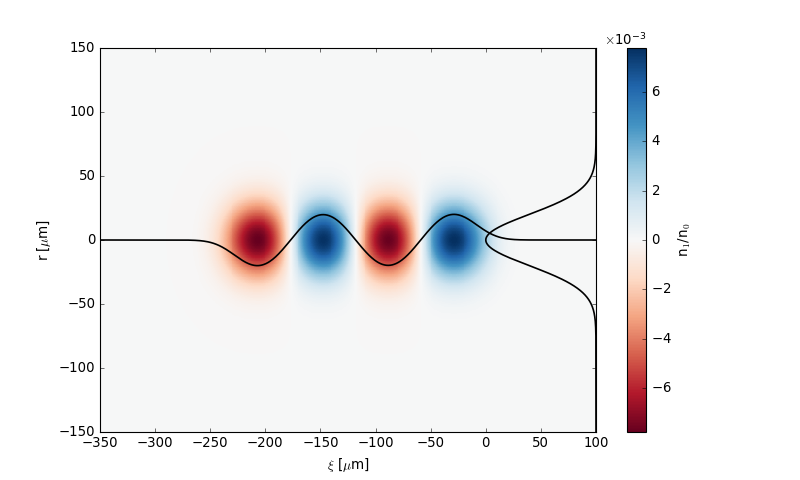

In [13]:
# for xi0 in np.arange(-200e-6, 0., 10e-6):
Xi_1, R_1, n_1 = n1(r, dr, xi, dz, Nb, n0, gauss = g, load = l, mu_w = xi0)

# N1 = makefield([quad(lambda Z: np.exp(-Z**2 / (2 * dz**2)) * np.sin(kp * (z - Z)), z, 1e-3)[0] for z in xi], -kp * Nb / ((2 * np.pi)**1.5 * dr**2 * dz * 1e6 * n0) * np.exp(-r**2 / (2 * dr**2)))

plt.close()
plt.figure(4, figsize = (10, 6), facecolor = 'w')
img = plt.pcolormesh(1e6 * xi, 1e6 * r, n_1, cmap = 'RdBu') #, vmin = -1e-3, vmax = 1e-3) # why did we need to multiply by 1e-5?  Where did it come from?
# plt.pcolormesh(1e6 * info.z, 1e6 * info.x, jz.T, cmap = 'Reds_rT')
# plt.xlim(1e6 * ximax, 1e6 * ximin)
plt.xlim(1e6 * ximin, 1e6 * ximax)
plt.ylim(1e6 * rmin, 1e6 * rmax)
plt.xlabel(r'$\xi$ [$\mu$m]')
plt.ylabel(r'r [$\mu$m]')

plt.plot(1e6 * xi, 20 * max(Xi_1)**-1 * Xi_1, 'k', linewidth = 1.5)
plt.plot(-1e2 * max(R_1)**-1 * R_1 + 100, 1e6 * r, 'k', linewidth = 1.5)

cb = plt.colorbar(img)
cb.formatter.set_powerlimits((0, 0))
cb.formatter.set_useMathText(True)
cb.set_label(r'n$_1$/n$_0$')

plt.show()

In [ ]:
analytical = False
coord = ''
GeV = False

Xi, R, E_z = Ez(r, dr, xi, dz, Nb, n0, gauss = g, load = l, mu_w = xi0, eV = GeV)
zR, E_zR = EzR_analytic(r, dr, xi, dz, Nb, n0, eV = GeV)

# print((E_zR / E_z)[0,0], 1e6 * skinDepth(n0) ** -1)

# m = (info.z > -150e-6) & (info.z < -100e-6)
# witnessIdx = np.argmax(Xi[m])
# witnessPos = 1e6 * (info.z[m][witnessIdx] + dz)
# print(witnessPos)

plt.close()
plt.figure(5, figsize = (10, 6), facecolor = 'w')

if coord == 'kp':
    kp = skinDepth(n0) ** -1 # m^-1

    if analytical:
        img = plt.pcolormesh(kp * xi, kp * r, E_zR, cmap = 'RdBu') # , vmin = -5e-3, vmax = 5e-3)
        plt.plot(100e-6 * kp * (max(R)**-1 * R - 1), kp * r, 'k', linewidth = 1.5)
    else:
        img = plt.pcolormesh(kp * xi, kp * r, E_z, cmap = 'RdBu') # , vmin = -5e-3, vmax = 5e-3)
        plt.plot(100e-6 * kp * (max(R)**-1 * R - 1), kp * r, 'k', linewidth = 1.5)


    plt.plot(kp * xi, 5e-14 * Xi, 'k', linewidth = 1.5)

    plt.xlim(kp * ximax, kp * ximin)
    # plt.ylim(-3.5, 3.5)
    plt.ylim(kp * rmin, kp * rmax)
    plt.xlabel(r'$k_p\xi$')
    plt.ylabel(r'$k_p r$')
else:
    if analytical:
        img = plt.pcolormesh(1e6 * xi, 1e6 * r, E_zR, cmap = 'RdBu') # , vmin = -1e4, vmax = 1e4)
        plt.plot(-1e2 * max(zR)**-1 * zR + 100, 1e6 * r, 'k', linewidth = 1.5)
    else:
        img = plt.pcolormesh(1e6 * xi, 1e6 * r, E_z, cmap = 'RdBu')
        plt.plot(-1e2 * max(R)**-1 * R + 100, 1e6 * r, 'k', linewidth = 1.5)

    plt.plot(1e6 * xi, 20 * max(Xi)**-1 * Xi, 'k', linewidth = 1.5)
    
    # plt.vlines(1e6 * xi0, 1e6 * rmin, 1e6 * rmax, 'gray', ls = '--')
    # plt.vlines(witnessPos, 1e6 * rmin, 1e6 * rmax, 'gray', ls = '--')
    # plt.vlines(2e6 * -dz, 1e6 * rmin, 1e6 * rmax, 'gray', ls = '--')
    # plt.vlines(1e6 * xi0, 1e6 * rmin, 1e6 * rmax, color = 'gray', ls = '--')

    plt.xlim(1e6 * ximin, 1e6 * ximax)
    plt.ylim(1e6 * rmin, 1e6 * rmax)
    plt.xlabel(r'$\xi$ [$\mu$m]')
    plt.ylabel(r'r [$\mu$m]')

cb = plt.colorbar(img)
cb.formatter.set_powerlimits((0, 0))
cb.formatter.set_useMathText(True)

if GeV:
    cb.set_label(r'$E_z$ [GeV$\cdot$m$^{-1}$]')
else:
    cb.set_label(r'$E_z$/$E_0$')

plt.show()

In [ ]:
GeV = False
Xi, R, E_r = Er(r, dr, xi, dz, Nb, n0, gauss = g, load = l, mu_w = xi0, eV = GeV)

plt.close()
plt.figure(6, figsize = (10, 6), facecolor = 'w')
img = plt.pcolormesh(1e6 * xi, 1e6 * r, E_r, cmap = 'RdBu') #, vmin = -1e-3, vmax = 1e-3) # why did we need to multiply by 1e-5?  Where did it come from?

plt.xlim(1e6 * ximin, 1e6 * ximax)
# plt.xlim(1e6 * ximax, 1e6 * ximin)
plt.ylim(1e6 * rmin, 1e6 * rmax)
plt.xlabel(r'$\xi$ [$\mu$m]')
plt.ylabel(r'r [$\mu$m]')

plt.plot(1e6 * xi, 20 * max(Xi)**-1 * Xi, 'k', linewidth = 1.5)
plt.plot(-.325e2 * max(R)**-1 * R - 25, 1e6 * r, 'k', linewidth = 1.5)

cb = plt.colorbar(img)
cb.formatter.set_powerlimits((0, 0))
cb.formatter.set_useMathText(True)

if GeV:
    cb.set_label(r'$E_r$ [GeV$\cdot$m$^{-1}$]')
else:
    cb.set_label(r'$E_r$/$E_0$')

plt.show()

In [ ]:
# zR, E_zR = EzR_analytic(r, dr, xi, dz, Nb, n0)
# _, R, _ = Ez(r, dr, xi, dz, Nb, n0, gauss = False)
_, R, _ = Er(r, dr, xi, dz, Nb, n0, gauss = False)

# zR = np.nan_to_num(zR)

plt.close()
plt.figure(7, figsize = (10, 6), facecolor = 'w')

# plt.plot(1e6 * r, g1(dr, r, n0), 'r--', linewidth = 1.5)
plt.plot(1e6 * r, R, 'k', linewidth = 1.5)
# plt.plot(1e6 * r, max(R)**-1 * R, 'r', linewidth = 1., label = 'Numerical')
# plt.plot( 1e6 * r, max(zR)**-1 * zR, 'k--', linewidth = 1.75, label = 'Analytic')
# plt.plot( 1e6 * r, leftright(50e-6, r)[1], 'k:', linewidth = 1.5)
# plt.plot( 1e6 * r, (R * zR), 'b', linewidth = 1.5)
# plt.plot( 1e6 * r, g(r0, r, n0) * r0 * 1e6, linewidth = 1.5)
# plt.legend()
# plt.ylim(-0.1, 1.1)
plt.xlabel('r')
plt.show()

# print(zR)

In [ ]:
kp = skinDepth(n0) ** -1 # µm^-1

Z = Nb * gaussian(xi, dz)
W_z = -kp * np.sin(kp * xi)

plt.close()
plt.figure(8, figsize = (10, 6), facecolor = 'w')
plt.plot(1e6 * xi, Z, 'k')
plt.plot(1e6 * xi, 1e-6 * np.convolve(Z, W_z)[:len(xi)], 'r')
plt.xlabel(r'$\xi$ ($\mu$m)')
plt.xlim(1e6 * xi[-1], 1e6 * xi[0])
plt.show()

In [ ]:
# Xi = Ez(r, dr, xi, dz, Nb, n0)[0]

# kp = skinDepth(n0) ** -1 # µm^-1

# Z = Nb * gaussian(xi, dz)
# W_z = kp * np.sin(1e6 * kp * xi)
# W_Ez = -kp * np.cos(1e6 * kp * xi)

z = longitudinal(xi, dz, Nb, n0, True)

plt.close()
plt.figure(9, figsize = (10, 6), facecolor = 'w')
# plt.plot(1e6 * xi, longitudinal(-xi, dz, Nb, n0, True), 'k--', linewidth = 2.)
plt.plot(1e6 * xi, z, 'k', linewidth = 1.)
# for i in np.arange(0.,  50e-6, 10e-6):
#     plt.plot(1e6 * xi, longitudinal(xi + i, dz, Nb, n0, True))
# plt.plot(1e6 * xi, np.convolve(Z, W_z)[:len(xi)], 'b')
# plt.plot(1e6 * xi, np.convolve(Z, W_Ez)[:len(xi)], 'r')
# plt.plot(1e6 * xi, Xi, 'r')
plt.xlabel(r'$\xi$ ($\mu$m)')
plt.xlim(1e6 * xi[0], 1e6 * xi[-1])
# plt.xlim(1e6 * xi[-1], 1e6 * xi[0])
# plt.legend([r'n$_1$/n$_0$', r'$E_z(\xi)$'])
# plt.yticks([])
plt.show()

In [12]:
GeV2P(10)

19569.511835738733

In [ ]:
ts.slider(cmap = 'RdBu')

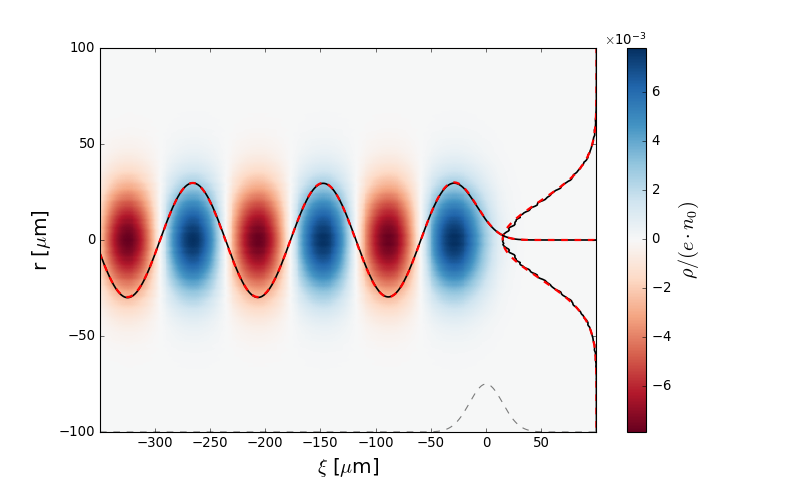

In [11]:
Xi_1, R_1, n_1 = n1(r, dr, xi, dz, Nb, n0, gauss = g, load = l, mu_w = xi0)
z = longitudinal(xi, dz, Nb, n0, True, gauss = g, load = l, mu_w = xi0)

off = 0 # -5e-6

idx = np.argmin(abs(info.x - off))

plt.close()
plt.figure(11, figsize = (10, 6), facecolor = 'w')
# img = plt.pcolormesh(1e6 * info.z, 1e6 * info.x, rho[:, 511//2].T * 1e-6 / (constants.e * n0), cmap = 'RdBu')
img = plt.pcolormesh(1e6 * info.z, 1e6 * info.x, rho.T * 1e-6 / (constants.e * n0), cmap = 'RdBu')
# plt.scatter(1e6 * info.z, 50 * profile / max(profile) - 150, edgecolor = 'k', s = .1)
# plt.plot(1e6 * info.z, 50 * profile / max(profile) - 150, 'k', alpha = .5)
# plt.plot(1e6 * info.z, 50 * abs(jz[:, 514]) / max(abs(jz[:, 514])) - 150, 'k', alpha = .5)
if not l:
    plt.plot(1e6 * info.z, 25 * gaussian(info.z, dz, 0)/max(gaussian(info.z, dz, 0)) - 100, 'k--', alpha = .5)
else:
    plt.plot(1e6 * info.z, 25 * gaussian2(info.z, dz, 0, dz, -3*np.pi*kp**-1)/max(gaussian2(info.z, dz, 0, dz, -3*np.pi*kp**-1)) - 100, 'k--', alpha = .5)

# plt.plot(1e2 * max(abs(rho[idx, 511//2]))**-1 * rho[idx, 511//2] + 100, 1e6 * info.x, 'k', linewidth = 1.5, label = 'HiPACE++')
plt.plot(-.85e2 * max(abs(rho[idx]))**-1 * rho[idx] + 100, 1e6 * info.x, 'k', linewidth = 1.5, label = 'HiPACE++')
# plt.plot(1.05e1 * max(rho[0, 511//2])**-1 * rho[0, 511//2] + 100, 1e6 * info.x, 'k', linewidth = 1.5, label = 'HiPACE++')
plt.plot(-.85e2 * max(R_1)**-1 * R_1 + 100, 1e6 * r, 'r--', linewidth = 2., label = 'Analytic')

# plt.plot(1e6 * info.z, 30 * max(abs(rho[:, 511//2, 511//2]))**-1 * rho[:, 511//2, 511//2], 'k', linewidth = 1.5)
plt.plot(1e6 * info.z, 30 * max(abs(rho[:, len(rho)//2]))**-1 * rho[:, len(rho)//2], 'k', linewidth = 1.5)
plt.plot(1e6 * xi, 30 * max(abs(z))**-1 * z, 'r--', linewidth = 2.)
# plt.plot(-1e6 * xi, 30 * max(abs(Xi_1))**-1 * Xi_1, 'c--', linewidth = 2.)
# if not g:

# plt.vlines(1e6 * off, 1e6 * info.xmin, 1e6 * info.xmax, linestyles = '--', linewidth = 1., color = 'gray')

plt.xlim(1e6 * info.zmin, 1e6 * info.zmax)
plt.ylim(-100, 100)
# plt.ylim(1e6 * info.xmin, 1e6 * info.xmax)
plt.xlabel(r'$\xi$ [$\mu$m]', fontsize = 18)
plt.ylabel(r'r [$\mu$m]', fontsize = 18)

cb = plt.colorbar(img)
cb.formatter.set_powerlimits((0, 0))
cb.formatter.set_useMathText(True)
# cb.set_label(r'n$_1$/n$_0$', fontsize = 18)
cb.set_label(r'$\rho/(e \cdot n_0)$', fontsize = 18)

# plt.legend()
# plt.savefig('/Users/max/HiPACE/recovery/images/n1Loaded.png', bbox_inches = 'tight', dpi = 300)
plt.show()

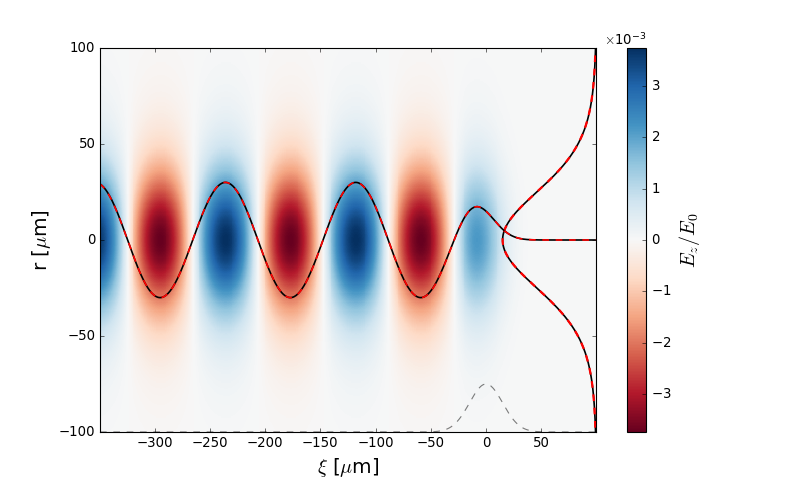

In [12]:
_, R, _ = Ez(r, dr, xi, dz, Nb, n0, gauss = g, load = l, mu_w = xi0, eV = False)
z = longitudinal(xi, dz, Nb, n0, False, gauss = g, load = l, mu_w = xi0)

Xoff = 0 # 25e-6
Zoff = 0 # -10e-6
# Zoff = -85e-6
Xid = np.argmin(abs(info.z - Xoff))
Zid = np.argmin(abs(info.z - Zoff))

idx = np.argmin(abs(info.z + 120e-6))

m1 = abs(xi) < 50e-6
m2 = np.logical_and(abs(xi) > 100e-6, abs(xi) < 200e-6)
fPeak = np.argmax(abs(z[m1]))
sPeak = np.argmax(z[m2])

plt.close()
plt.figure(10, figsize = (10, 6), facecolor = 'w')
# img = plt.pcolormesh(1e6 * info.z, 1e6 * info.x, EZ[:, 511//2].T / E0(n0), cmap = 'RdBu')
img = plt.pcolormesh(1e6 * info.z, 1e6 * info.x, EZ.T / E0(n0), cmap = 'RdBu')

# plt.plot(-1e2 * max(abs(EZ[0, 511//2]))**-1 * EZ[0, 511//2] + 100, 1e6 * info.x, 'k', linewidth = 1.5, label = 'HiPACE++')
plt.plot(-.85e2 * max(abs(EZ[Zid]))**-1 * EZ[Zid] + 100, 1e6 * info.x, 'k', linewidth = 1.5, label = 'HiPACE++')
plt.plot(-.85e2 * max(R)**-1 * R + 100, 1e6 * r, 'r--', linewidth = 2., label = 'Analytic')

if not l:
    plt.plot(1e6 * info.z, 25 * gaussian(info.z, dz, 0)/max(gaussian(info.z, dz, 0)) - 100, 'k--', alpha = .5)
else:
    plt.plot(1e6 * info.z, 25 * gaussian2(info.z, dz, 0, dz, -3*np.pi*kp**-1)/max(gaussian2(info.z, dz, 0, dz, -3*np.pi*kp**-1)) - 100, 'k--', alpha = .5)

# plt.vlines(Zoff * 1e6, 1e6 * info.xmin, 1e6 * info.xmax, 'gray', linestyle = '--')

# plt.plot(1e6 * info.z, 30 * max(abs(EZ[:, 511//2, 511//2]))**-1 * EZ[:, 511//2, 511//2], 'k', linewidth = 1.5)
plt.plot(1e6 * info.z, 30 * max(abs(EZ[:, 511//2]))**-1 * EZ[:, 511//2], 'k', linewidth = 1.5)
plt.plot(1e6 * xi, 30 * max(abs(z))**-1 * z, 'r--', linewidth = 1.5)
# plt.scatter(-1e6 * xi[m1][fPeak], 30 * max(abs(z))**-1 * z[m1][fPeak], c = 'b')
# plt.scatter(-1e6 * xi[m2][sPeak], 30 * max(abs(z))**-1 * z[m2][sPeak], c = 'b')

plt.xlim(1e6 * info.zmin, 1e6 * info.zmax)
plt.ylim(-100, 100)
# plt.ylim(1e6 * info.xmin, 1e6 * info.xmax)
plt.xlabel(r'$\xi$ [$\mu$m]', fontsize = 18)
plt.ylabel(r'r [$\mu$m]', fontsize = 18)

cb = plt.colorbar(img)
cb.formatter.set_powerlimits((0, 0))
cb.formatter.set_useMathText(True)
cb.set_label(r'$E_z/E_0$', fontsize = 18)
# plt.legend()
# plt.savefig('/Users/max/HiPACE/recovery/images/EzUnloaded.png', bbox_inches = 'tight', dpi = 300)
plt.show()

# print(abs(z[m1][fPeak] / z[m2][sPeak]))

/var/folders/l9/q33h82k16xx50gmpcg10_ymh0000gn/T/ipykernel_45136/1868855090.py:116: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Xi = np.array([quad(lambda Z: -kp * Nb * gaussian2(Z, dz, 0, dz, mu_w) * np.sin(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1
/var/folders/l9/q33h82k16xx50gmpcg10_ymh0000gn/T/ipykernel_45136/1868855090.py:116: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Xi = np.array([quad(lambda Z: -kp * Nb * gaussian2(Z, dz, 0, dz, mu_w) * np.sin(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1


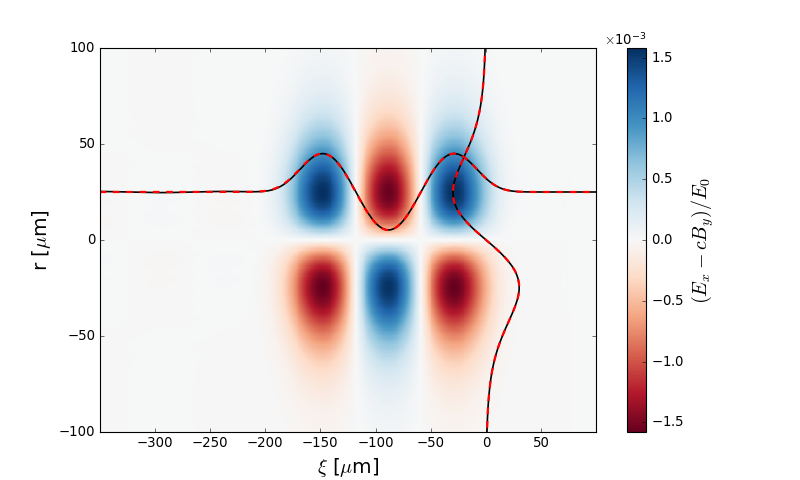

In [18]:
Xi, R, E_r = Er(r, dr, xi, dz, Nb, n0, gauss = g, load = l, mu_w = xi0, eV = False)
z = longitudinal(xi, dz, Nb, n0, True, gauss = g, load = l, mu_w = xi0)

Xoff = 25e-6
Zoff = 0 # -30e-6
# Zoff = -85e-6
Xid = np.argmin(abs(info.z - Xoff))
Zid = np.argmin(abs(info.z - Zoff))

plt.close()
plt.figure(12, figsize = (10, 6), facecolor = 'w')
# img = plt.pcolormesh(1e6 * info.z, 1e6 * info.x, ExmBy[:, 511//2].T / E0(n0), cmap = 'RdBu')
img = plt.pcolormesh(1e6 * info.z, 1e6 * info.x, ExmBy.T / E0(n0), cmap = 'RdBu')

# plt.hlines(1e6 * Xoff, 1e6 * info.zmin, 1e6 * info.zmax, linestyles = ':', linewidth = 2., color = 'gray')
# plt.vlines(1e6 * Zoff, 1e6 * info.xmin, 1e6 * info.xmax, linestyles = ':', linewidth = 2., color = 'gray')

# plt.plot(-.3e2 * max(abs(ExmBy[Zid, 511//2]))**-1 * ExmBy[Zid, 511//2] + 1e6 * Zoff, 1e6 * info.x, 'k', linewidth = 1.5, label = 'HiPACE++')
plt.plot(-.3e2 * max(abs(ExmBy[Zid]))**-1 * ExmBy[Zid] + 1e6 * Zoff, 1e6 * info.x, 'k', linewidth = 1.5, label = 'HiPACE++')
plt.plot(-.3e2 * max(R)**-1 * R + 1e6 * Zoff, 1e6 * r, 'r--', linewidth = 2., label = 'Analytic')

# plt.plot(1e6 * info.z, 20 * max(abs(ExmBy[:, Xid, Xid]))**-1 * ExmBy[:, Xid, Xid] + 1e6 * Xoff, 'k', linewidth = 1.5)
plt.plot(1e6 * info.z, 20 * max(abs(ExmBy[:, Xid]))**-1 * ExmBy[:, Xid] + 1e6 * Xoff, 'k', linewidth = 1.5)
plt.plot(1e6 * xi, 20 * max(abs(z))**-1 * z + 1e6 * Xoff, 'r--', linewidth = 2.)
# plt.plot(1e6 * info.z, 30 * max(abs(ExmBy[:, 511//4, 511//2]))**-1 * ExmBy[:, 511//2, 511//2], 'k', linewidth = 1.)
# plt.plot(-1e6 * xi, 30 * max(Xi)**-1 * Xi, 'r--', linewidth = 2.)

plt.xlim(1e6 * info.zmin, 1e6 * info.zmax)
plt.ylim(-100, 100)
# plt.ylim(1e6 * info.xmin, 1e6 * info.xmax)
plt.xlabel(r'$\xi$ [$\mu$m]', fontsize = 18)
plt.ylabel(r'r [$\mu$m]', fontsize = 18)

cb = plt.colorbar(img)
cb.formatter.set_powerlimits((0, 0))
cb.formatter.set_useMathText(True)
cb.set_label(r'$(E_x-cB_y)/E_0$', fontsize = 18)
# plt.legend(loc = 'upper left')
# plt.savefig('images/GaussianErBothLoaded.png')
plt.show()

In [ ]:
_, _, n_1 = n1(r, dr, xi, dz, Nb, n0, gauss = g)

plt.close()
plt.figure(15, figsize = (10, 6), facecolor = 'w')
# img = plt.pcolormesh(1e6 * info.z, 1e6 * info.x, np.nan_to_num(rho[:, 511//2].T / (n_1 * 1e6 * n0)), cmap = 'jet', norm = matplotlib.colors.LogNorm())

plt.semilogy(1e6 * xi, np.nan_to_num(rho[:, 511//2, 511//2].T / (n_1[511//2, :] * 1e6 * n0)))

plt.xlim(1e6 * info.zmin, 1e6 * info.zmax)
# plt.ylim(1e6 * info.xmin, 1e6 * info.xmax)
plt.xlabel(r'$\xi$ [$\mu$m]')
plt.ylabel(r'r [$\mu$m]')

# cb = plt.colorbar(img)
# cb.formatter.set_powerlimits((0, 0))
# cb.formatter.set_useMathText(True)
# cb.set_label(r'$(E_x-cB_y)/{E_r}^{a}$')

plt.show()

/var/folders/l9/q33h82k16xx50gmpcg10_ymh0000gn/T/ipykernel_27769/714183008.py:122: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Xi = -np.array([quad(lambda Z: -kp * Nb * gaussian2(Z, dz, 0, dz, mu_w) * np.cos(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1 EXTRA MINUS SIGN NEEDS TO BE ADDRESSED
/var/folders/l9/q33h82k16xx50gmpcg10_ymh0000gn/T/ipykernel_27769/714183008.py:122: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Xi = -np.array([quad(lambda Z: -kp * Nb * gaussian2(Z, dz, 0, dz, mu_w) * np.cos(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1 EXTRA MINUS SIGN NEEDS TO BE ADDRESSED
/var/folders/l9/q33h82k16xx50gmpcg10_ymh0000gn/T/ipykernel_27769/714183008.py:116: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
 

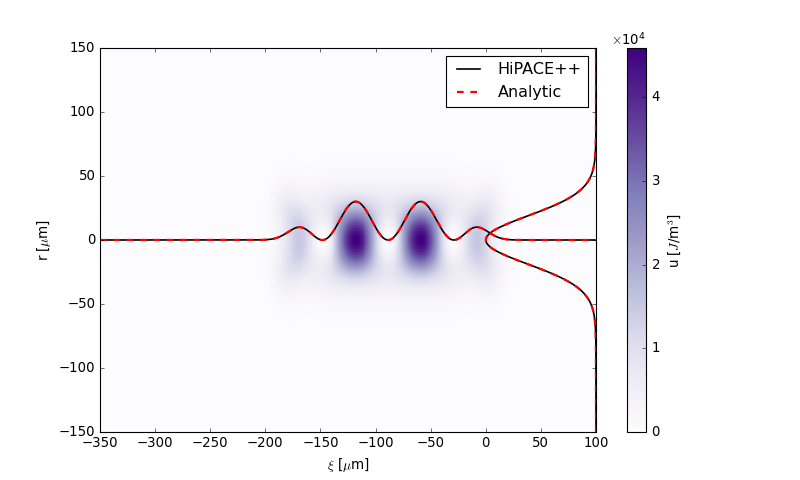

In [85]:
# m = (info.z > -140e-6) & (info.z < -100e-6)
# witnessIdx = np.argmax(uSim[:, idx][m])
# witnessPos = 1e6 * info.z[m][witnessIdx]
# print(witnessPos)

u = EDensity(r, dr, xi, dz, Nb, n0, gauss = g, load = l, mu_w = xi0)
off = 0
idx = np.argmin(abs(info.x - off))

plt.close()
plt.figure(13, figsize = (10, 6), facecolor = 'w')
# img = plt.pcolormesh(1e6 * domain.z, 1e6 * domain.x, uSim[:, len(domain.x)//2].T, cmap = 'Purples')
img = plt.pcolormesh(1e6 * domain.z, 1e6 * domain.x, uSim.T, cmap = 'Purples')

# plt.plot(-1e2 * max(abs(uSim[idx, 511//2]))**-1 * uSim[idx, 511//2] + 100, 1e6 * info.x, 'k', linewidth = 1.5, label = 'HiPACE++')
plt.plot(-1e2 * max(abs(uSim[idx]))**-1 * uSim[idx] + 100, 1e6 * info.x, 'k', linewidth = 1.5, label = 'HiPACE++')
plt.plot(-1e2 * max(u[:, 511//2])**-1 * u[:, 511//2] + 100, 1e6 * r, 'r--', linewidth = 2., label = 'Analytic')

# plt.plot(1e6 * info.z, 30 * max(abs(uSim[:, 511//2, 511//2]))**-1 * uSim[:, 511//2, 511//2], 'k', linewidth = 1.5)
plt.plot(1e6 * info.z, 30 * max(abs(uSim[:, 511//2]))**-1 * uSim[:, 511//2], 'k', linewidth = 1.5)
plt.plot(1e6 * xi, 30 * max(abs(u[511//2, :]))**-1 * u[511//2, :], 'r--', linewidth = 2.)

# plt.vlines(1e6 * off, 1e6 * rmin, 1e6 * rmax, color = 'gray', ls = '--')

plt.xlim(1e6 * ximin, 1e6 * ximax)
plt.ylim(1e6 * rmin, 1e6 * rmax)
plt.xlabel(r'$\xi$ [$\mu$m]')
plt.ylabel(r'r [$\mu$m]')

cb = plt.colorbar(img)
cb.formatter.set_powerlimits((0, 0))
cb.formatter.set_useMathText(True)
cb.set_label(r'u [$J$/m$^{3}$]')
plt.legend()
# plt.title('HiPACE++')
# plt.savefig('images/GaussianUBothLoaded.png')
plt.show()

In [ ]:
u = EDensity(r, dr, xi, dz, Nb, n0, gauss = g, load = l, mu_w = xi0)

plt.close()
plt.figure(14, figsize = (10, 6), facecolor = 'w')
img = plt.pcolormesh(1e6 * xi, 1e6 * r, u, cmap = 'Purples')
# img = plt.pcolormesh(1e6 * xi, 1e6 * r, u, cmap = 'Reds', norm = matplotlib.colors.LogNorm())

plt.xlim(1e6 * ximin, 1e6 * ximax)
plt.ylim(1e6 * rmin, 1e6 * rmax)
plt.xlabel(r'$\xi$ [$\mu$m]')
plt.ylabel(r'r [$\mu$m]')

cb = plt.colorbar(img)
cb.formatter.set_powerlimits((0, 0))
cb.formatter.set_useMathText(True)
cb.set_label(r'u [$J$/m$^{3}$]')

plt.title('Analytic')
plt.show()

In [ ]:
Xi, R, BPhi = Bphi(r, dr, xi, dz, Nb, n0, gauss = g)

plt.close()
plt.figure(15, figsize = (10, 6), facecolor = 'w')
img = plt.pcolormesh(1e6 * xi, 1e6 * r, BPhi, cmap = 'RdBu')
# img = plt.pcolormesh(1e6 * xi, 1e6 * r, u, cmap = 'Reds', norm = matplotlib.colors.LogNorm())

plt.plot(1e6 * xi, 20 * max(abs(Xi))**-1 * Xi + 25, 'k', linewidth = 1.5)
plt.plot(-.325e2 * max(R)**-1 * R, 1e6 * r, 'k', linewidth = 1.5)

plt.xlim(1e6 * ximin, 1e6 * ximax)
plt.ylim(1e6 * rmin, 1e6 * rmax)
plt.xlabel(r'$\xi$ [$\mu$m]')
plt.ylabel(r'r [$\mu$m]')

cb = plt.colorbar(img)
cb.formatter.set_powerlimits((0, 0))
cb.formatter.set_useMathText(True)
cb.set_label(r'$B_\phi$ [T]')

plt.show()

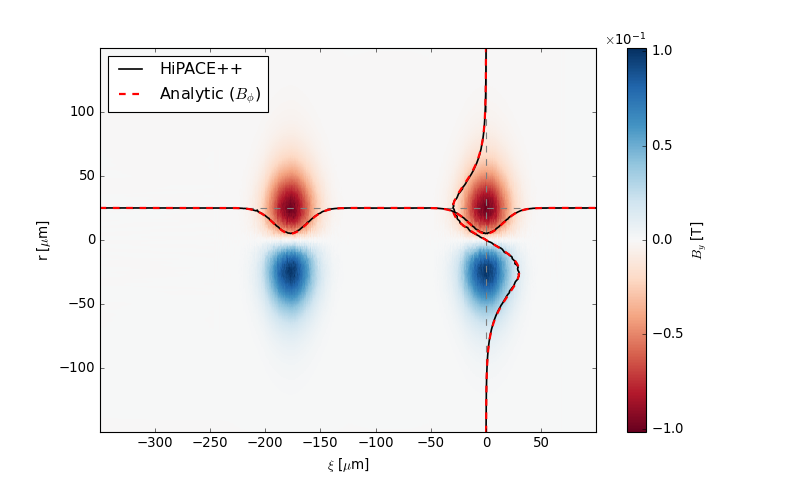

In [105]:
Xi, R, BPhi = Bphi(r, dr, xi, dz, Nb, n0, gauss = g, load = l, mu_w = xi0)

Xoff = 25e-6
Zoff = 0. # 2.5e-6
# Zoff = -85e-6
Xid = np.argmin(abs(info.z - Xoff))
Zid = np.argmin(abs(info.z - Zoff))

plt.close()
plt.figure(12, figsize = (10, 6), facecolor = 'w')
img = plt.pcolormesh(1e6 * info.z, 1e6 * info.x, By.T, cmap = 'RdBu')

plt.hlines(1e6 * Xoff, 1e6 * info.zmin, 1e6 * info.zmax, linestyles = '--', linewidth = 1., color = 'gray')
plt.vlines(1e6 * Zoff, 1e6 * info.xmin, 1e6 * info.xmax, linestyles = '--', linewidth = 1., color = 'gray')

plt.plot(.3e2 * max(abs(By[Zid]))**-1 * By[Zid] + 1e6 * Zoff, 1e6 * info.x, 'k', linewidth = 1.5, label = 'HiPACE++')
plt.plot(-.3e2 * max(R)**-1 * R + 1e6 * Zoff, 1e6 * r, 'r--', linewidth = 2., label = r'Analytic ($B_\phi$)')

plt.plot(1e6 * info.z, 20 * max(abs(By[:, Xid]))**-1 * By[:, Xid] + 1e6 * Xoff, 'k', linewidth = 1.5)
plt.plot(1e6 * xi, 20 * max(abs(Xi))**-1 * Xi + 1e6 * Xoff, 'r--', linewidth = 2.)

plt.xlim(1e6 * info.zmin, 1e6 * info.zmax)
plt.ylim(1e6 * info.xmin, 1e6 * info.xmax)
plt.xlabel(r'$\xi$ [$\mu$m]')
plt.ylabel(r'r [$\mu$m]')

cb = plt.colorbar(img)
cb.formatter.set_powerlimits((0, 0))
cb.formatter.set_useMathText(True)
cb.set_label(r'$B_y$ [T]')
plt.legend(loc = 'upper left')

# plt.savefig('images/StepBphiBothLoaded.png')
plt.show()

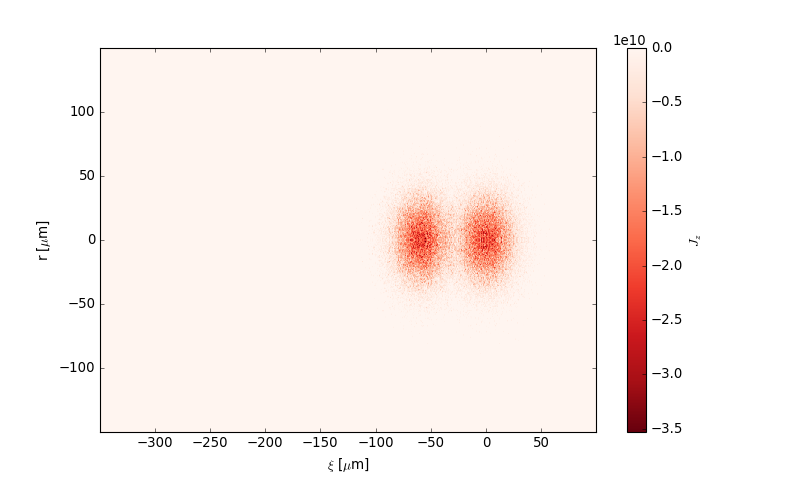

In [86]:
plt.close()
plt.figure(13, figsize = (10, 6), facecolor = 'w')
img = plt.pcolormesh(1e6 * info.z, 1e6 * info.x, jz.T, cmap = 'Reds_r')
# plt.vlines(2e6 * -dz, 1e6 * rmin, 1e6 * rmax, 'gray', ls = '--')

plt.xlim(1e6 * info.zmin, 1e6 * info.zmax)
plt.ylim(1e6 * info.xmin, 1e6 * info.xmax)
plt.xlabel(r'$\xi$ [$\mu$m]')
plt.ylabel(r'r [$\mu$m]')

cb = plt.colorbar(img)
# cb.formatter.set_powerlimits((0, 0))
# cb.formatter.set_useMathText(True)
cb.set_label(r'$J_z$')

plt.show()